### Overview of Random Forest
**Random Forest** is a powerful and versatile supervised machine learning algorithm belonging to the **ensemble learning** family. The core idea of ensemble learning is that by combining the predictions of multiple "weak" or "decent" models, you can create a single "strong" model that is more accurate and robust.

Random Forest operates by constructing a large number of **Decision Trees** at training time and outputting the class that is the **mode** (majority vote) of the classes (for classification) or the **mean** prediction (for regression) of the individual trees.

Its strength comes from two key sources of randomness, which are designed to "de-correlate" the trees:
  1. **Bagging (Bootstrap Aggregating)**: This is the "random data" component. Each individual tree in the forest is trained on a different **bootstrap sample** of the original dataset. A bootstrap sample is created by randomly drawing $N$ samples from the original dataset of size $N$, with replacement. This means some data points will be selected multiple times, while others (on average, about 36.8%) will not be selected at all. These unselected samples are called the **Out-of-Bag (OOB)** samples.
  2. **Feature Randomness**: This is the "random features" component. When a single decision tree is built, it must decide how to split a node. Instead of considering all available features (e.g., "Age", "Income", "Location") to find the best possible split, the algorithm randomly selects a subset of $m$ features (e.g., just "Age" and "Location"). It then finds the best split only among that random subset.

This dual-randomness strategy ensures that the individual trees are different from each other. Even if a few trees are highly overfit or wrong, the collective "wisdom of the crowd" will cancel out their errors, leading to a model with low variance and high accuracy.

### How to Build a Random Forest
Let's assume we have a dataset with $N$ samples and $M$ features, and we want to build a forest with $k$ trees (defined by the `n_estimators` hyperparameter).

**For $t = 1$ to $k$ trees**:
  1. **Create a Bootstrap Sample**: Generate a new training set $D_t$, by sampling $N$ times from the original dataset with replacement. The remaining data $OOB_t$, will be used later.
  2. **Grow a Decision Tree**: Grow a tree $T_t$ on the bootstrap sample $D_t$. This tree is grown as follows:
     - Start at the root node with all data in $D_t$.
     - At each node, recursively repeat this process:
       - a. Randomly select $m$ features from the total $M$ features. A common heuristic is $m \approx \sqrt{M}$ for classification and $m \approx M/3$ for regression.
       - b. Find the "best split" (best feature $f^*$ and best threshold $\tau^*$) only from the $m$ selected features.
       - c. The "best split" is the one that maximizes **Information Gain (IG)**.
       - 
  **Mathematical Detail: Finding the "Best Split"**

  The algorithm chooses the split that results in the "purest" child nodes. Purity is measured using either **Gini Impurity** or **Entropy**.

  - **Gini Impurity**\
    Gini Impurity measures the probability of incorrectly classifying a randomly chosen element in the node if it were randomly labeled according to the class distribution in that node. For a node with $C$ classes, where $p_i$ is the fraction of samples belonging to class $i$: $$G = 1 - \sum_{i=1}^{C} (p_i)^2$$
    - A perfectly pure node (all samples are one class) has $G = 1 - (1^2) = 0$.
    - A 50/50 split (two classes) has $G = 1 - (0.5^2 + 0.5^2) = 0.5$.
  - **Entropy**\
    Entropy measures the amount of "disorder" or "uncertainty" in a node. $$H = -\sum_{i=1}^{C} p_i \log_2(p_i)$$
    - A perfectly pure node has $H = - (1 \log_2(1)) = 0$.
    - A 50/50 split has $H = - (0.5 \log_2(0.5) + 0.5 \log_2(0.5)) = 1$.
  - **Information Gain (IG)**\
    The algorithm picks the split that maximizes the $IG$. The $IG$ is the impurity of the parent node minus the weighted average impurity of the two child nodes. $$IG = \text{Impurity}(\text{Parent}) - \left( \frac{N_{\text{left}}}{N_{\text{total}}} \text{Impurity}(\text{Left}) + \frac{N_{\text{right}}}{N_{\text{total}}} \text{Impurity}(\text{Right}) \right)$$
    The tree is grown deep (usually not pruned) until a stopping criterion is met (e.g., `max_depth` or `min_samples_split`).

  3. **Final Prediction (Aggregation)**: After all $k$ trees are built, a new unseen sample $x'$ is passed through the entire forest:
    - **For Classification**: Each of the $k$ trees gives a class prediction (a "vote"). The final prediction is the **majority vote**. $$\text{Prediction} = \text{argmax}_{c} \left( \sum_{t=1}^{k} \mathbb{I}(T_t(x') = c) \right)$$
      (where $\mathbb{I}$ is the indicator function)
    - **For Regression**: Each of the $k$ trees gives a continuous value prediction. The final prediction is the **average** of all $k$ values. $$\text{Prediction} = \frac{1}{k} \sum_{t=1}^{k} T_t(x')$$

### How Random Forest Handles Missing Values
This is a common point of confusion. How it's handled depends entirely on the implementation (the library you are using).
  - **Scikit-learn**: The `sklearn.ensemble.RandomForestClassifier` and `RandomForestRegressor` **do not support missing values (NaNs) natively**. If you pass a DataFrame with NaNs into the `.fit()` method, it will raise an error. You are required to **pre-process** the data yourself using techniques like:
    - **Imputation**: Filling the missing values with the mean, median (for numerical data), or mode (for categorical data). `sklearn.impute.SimpleImputer` is often used.
    - **Advanced Imputation**: Using models like `sklearn.impute.KNNImputer` to predict the missing values based on their neighbors.
    - **Indicator Variables**: Adding a new binary column (e.g., `Age_was_missing`) that is 1 if the "Age" was missing and 0 otherwise. This is often done in addition to imputation.
  - **Theoretical / Original Implementation (e.g., in R's `randomForest` package)**: The original algorithm by Leo Breiman had built-in mechanisms for this:
    - **Proximity-Based Imputation**: The algorithm first calculates a "proximity" matrix between all samples (how often two samples end up in the same leaf node). Then, it imputes missing values by taking a weighted average (for regression) or a weighted vote (for classification) from the samples that are most "proximate" or similar to it. This process can be iterated.
    - **Splitting Heuristics**: During training, if a node needs to be split on a feature with missing values, the algorithm can "learn" which direction (left or right child) to send the missing values by seeing which choice leads to a purer split.

**In summary**: For practical purposes (especially in Python), you must handle missing values before training your Random Forest.

### How Random Forest Evaluates Feature Importance
Random Forest provides two primary methods to understand which features are most impactful on the model's predictions.
1. **Mean Decrease in Impurity (MDI)**\
  This is the most common, fastest, and default method (e.g., the `.feature_importances_` attribute in scikit-learn).
  - **How it works**: Every time a feature is used to split a node in a tree, the **Information Gain (or Gini Decrease)** it produces is recorded. This "gain" is the feature's "contribution" at that split.
  - The total importance for a single feature in one tree is the sum of all Gini Decreases it contributed to across all splits in that tree.
  - The final importance score for that feature across the entire forest is the **average of its scores across all trees**.
  - The scores are then typically normalized so that the sum of all feature importances equals 1.
  - **Drawback**: This method is fast but biased. It tends to artificially inflate the importance of high-cardinality features (features with many unique values, like a User ID) and continuous features over categorical features.

2. **Mean Decrease in Accuracy (MDA) or Permutation Importance**\
   This is a more reliable and intuitive method, but it is computationally expensive. It is calculated after the model is trained, typically on the **Out-of-Bag (OOB)** samples or a separate validation set.
   - **How it works**
     - **Baseline**: First, the model's accuracy (or R-squared for regression) is calculated on the OOB/validation set. This is the **baseline score**.
     - **Shuffle a Feature**: Next, take one feature column (e.g., "Age") and **randomly shuffle** (permute) its values. This action breaks any real association between "Age" and the target variable.
     - **Re-evaluate**: Pass this "broken" dataset through the already-trained forest and calculate the new accuracy. The accuracy will almost certainly drop.
     - **Calculate Importance**: The importance of "Age" is the **difference between the baseline score and the new, lower score**. `Importance_Age = Baseline_Accuracy - Shuffled_Accuracy`
     - **Repeat**: This process is repeated for every single feature in the dataset.
   - **Advantage**: This method directly measures how much the model relies on that feature for its predictions. It is unbiased and generally considered the more robust of the two methods.

### Advantages and Limitations
#### Advantages
- **High Accuracy**: It is one of the best-performing "off-the-shelf" algorithms and often works very well with little hyperparameter tuning.
- **Robust to Overfitting**: The combination of bagging and feature randomness creates a model with low variance, making it very difficult to overfit, even with very deep trees.
- **Handles Non-Linearity**: It can capture complex, non-linear relationships between features and the target.
- **No Need for Feature Scaling**: It is not sensitive to the scale of features (e.g., whether a feature is in meters or kilometers), unlike algorithms like SVM, Logistic Regression, or Neural Networks.
- **Handles High-Dimensionality**: It works well with datasets that have thousands of features.
- **Provides Feature Importance**: It offers built-in mechanisms (MDI and Permutation) to rank the importance of features.
#### Limitations
- **"Black Box" Model**: It is much less interpretable than a single Decision Tree. While you know which features are important, it's very difficult to explain how the forest made a specific prediction for a single data point.
- **Computationally Expensive**: It requires building and storing hundreds or thousands of trees, which can be slow to train and requires more memory than simpler models.
- **Prediction Speed**: Predictions are slower than in a single model because the input must pass through every tree in the forest.
- **Not Great for Sparse Data**: For very sparse, high-dimensional data (like text data represented as bag-of-words), linear models (like Logistic Regression or SVM) often perform better.
- **MDI Bias**: The default feature importance (MDI) can be misleading, as explained above.

### Breast Cancer RF Project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report

#### Load data

In [2]:
data = load_breast_cancer()
X = data.data
y = data.target

In [3]:
X.shape

(569, 30)

#### Split data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Build the Pipeline

In [5]:
# Step 1: 'scaler' - Standardize the data
# (Note: Random Forest does not *require* scaling,
# but it's good practice when building pipelines,
# as other models (like SVM, Logistic Regression) do require it)
# Step 2: 'model' - Random Forest model

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier(random_state=42))
])

#### Define the Parameter Grid

In [6]:
param_grid = {
    "model__n_estimators": [50, 100, 200],    # Number of trees
    "model__max_depth": [None, 10, 20],       # Maximum depth of each tree
    "model__max_features": ["sqrt", "log2"],  # Max features to consider at each split
    "model__min_samples_split": [2, 5]        # Minimum samples required to split a node
}

#### Initialize and Train GridSearchCV

In [7]:
# GridSearchCV will automatically try all parameter combinations
# using 5-fold Cross-Validation (cv=5)

grid_search = GridSearchCV(
    estimator=pipe,         # Our pipeline
    param_grid=param_grid,  # The parameter grid
    cv=5,                   # 5-fold cross-validation
    scoring="accuracy",     # Evaluate based on accuracy
    n_jobs=1,               # Use all CPU cores
    verbose=3               # Show messages
)

In [8]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END model__max_depth=None, model__max_features=sqrt, model__min_samples_split=2, model__n_estimators=50;, score=0.934 total time=   0.1s


[CV 2/5] END model__max_depth=None, model__max_features=sqrt, model__min_samples_split=2, model__n_estimators=50;, score=0.945 total time=   0.1s
[CV 3/5] END model__max_depth=None, model__max_features=sqrt, model__min_samples_split=2, model__n_estimators=50;, score=0.978 total time=   0.1s
[CV 4/5] END model__max_depth=None, model__max_features=sqrt, model__min_samples_split=2, model__n_estimators=50;, score=0.956 total time=   0.0s
[CV 5/5] END model__max_depth=None, model__max_features=sqrt, model__min_samples_split=2, model__n_estimators=50;, score=0.956 total time=   0.0s
[CV 1/5] END model__max_depth=None, model__max_features=sqrt, model__min_samples_split=2, model__n_estimators=100;, score=0.978 total time=   0.1s
[CV 2/5] END model__max_depth=None, model__max_features=sqrt, model__min_samples_split=2, model__n_estimators=100;, score=0.945 total time=   0.1s
[CV 3/5] END model__max_depth=None, model__max_features=sqrt, model__min_samples_split=2, model__n_estimators=100;, score=

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [None, 10, ...], 'model__max_features': ['sqrt', 'log2'], 'model__min_samples_split': [2, 5], 'model__n_estimators': [50, 100, ...]}"
,scoring,'accuracy'
,n_jobs,1
,refit,True
,cv,5
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


#### Evaluate results

In [9]:
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

Best parameters found: {'model__max_depth': None, 'model__max_features': 'log2', 'model__min_samples_split': 5, 'model__n_estimators': 50}
Best cross-validation accuracy: 0.9670


#### Get the best (pipeline) model

In [10]:
best_pipeline = grid_search.best_estimator_

In [11]:
y_pred = best_pipeline.predict(X_test)

In [12]:
report = classification_report(y_test, y_pred, target_names=data.target_names)
print(report)

              precision    recall  f1-score   support

   malignant       0.98      0.95      0.96        43
      benign       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



#### Visualize ONE TREE from the Forest

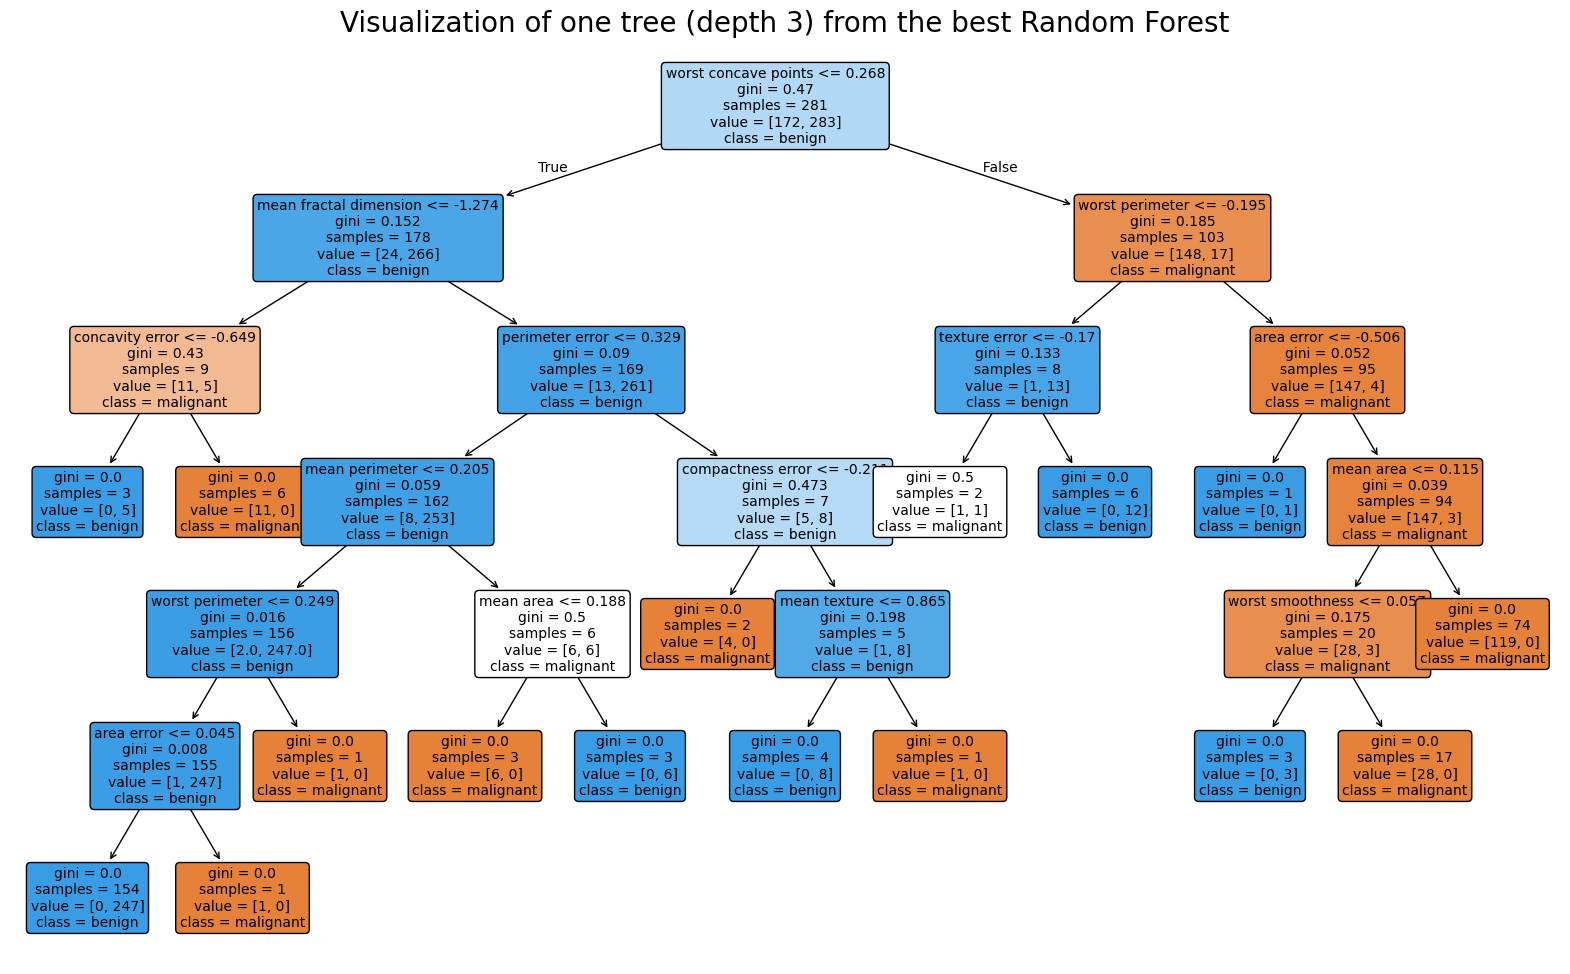

In [13]:
best_rf_model = best_pipeline.named_steps['model']

tree_to_plot = best_rf_model.estimators_[0]

plt.figure(figsize=(20, 12)) # Large size for readability
plot_tree(
    tree_to_plot, 
    feature_names=data.feature_names,
    class_names=data.target_names,
    filled=True,      # Fill nodes with color
    rounded=True,     # Rounded corners
    fontsize=10       # Font size
)
plt.title("Visualization of one tree (depth 3) from the best Random Forest", fontsize=20)
plt.show()